In [1]:
#@title Login
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /home/x_geohe/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [2]:
#!pip install -qqq diffusers==0.4.1 transformers ftfy gradio

In [2]:
def image_grid(imgs, rows, cols, grid=None):

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h)) if grid is None else grid
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [3]:
#@title Load the pipeline
import torch
from PIL import Image

from diffusers import LMSDiscreteScheduler, DiffusionPipeline, PNDMScheduler
from transformers import CLIPFeatureExtractor, CLIPModel, CLIPTextModel, CLIPTokenizer

model_id = "CompVis/stable-diffusion-v1-4" #@param {type: "string"}
clip_model_id = "openai/clip-vit-large-patch14" #@param ["laion/CLIP-ViT-B-32-laion2B-s34B-b79K", "laion/CLIP-ViT-L-14-laion2B-s32B-b82K", "laion/CLIP-ViT-H-14-laion2B-s32B-b79K", "laion/CLIP-ViT-g-14-laion2B-s12B-b42K", "openai/clip-vit-base-patch32", "openai/clip-vit-base-patch16", "openai/clip-vit-large-patch14"] {allow-input: true}
scheduler = "plms" #@param ['plms', 'lms']


def image_grid(imgs, rows, cols, grid=None):

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h)) if grid is None else grid
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

if scheduler == "lms":
    scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")
else:
    scheduler = PNDMScheduler.from_config(model_id, subfolder="scheduler")


feature_extractor = CLIPFeatureExtractor.from_pretrained(clip_model_id)
clip_model = CLIPModel.from_pretrained(clip_model_id, torch_dtype=torch.float32)
text_encoder = CLIPTextModel.from_pretrained(clip_model_id, torch_dtype=torch.float32)


lidar_feature = torch.load("/proj/nlp4adas/features/once_vit-l-14_val_lidar.pt")[3001:3002].to("cuda")
clip_model.get_text_features = lambda *args, **kwargs: lidar_feature

guided_pipeline = DiffusionPipeline.from_pretrained(
    model_id,
    custom_pipeline="clip_guided_stable_diffusion",
    clip_model=clip_model,
    feature_extractor=feature_extractor,
    text_encoder=text_encoder,
    scheduler=scheduler,
    revision="fp16",
    torch_dtype=torch.float32,
)
guided_pipeline = guided_pipeline.to("cuda")


The config attributes {'clip_sample': False} were passed to PNDMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.0.mlp.fc1.weight', 'vision_model.encoder.layers.1.mlp.fc2.bias', 'vision_model.encoder.layers.23.self_attn.k_proj.bias', 'vision_model.encoder.layers.18.mlp.fc1.weight', 'vision_model.encoder.layers.7.layer_norm1.bias', 'vision_model.encoder.layers.1.layer_norm1.bias', 'vision_model.encoder.layers.10.self_attn.q_proj.weight', 'vision_model.encoder.layers.5.layer_norm1.weight', 'vision_model.encoder.layers.16.mlp.fc2.weight', 'vision_model.encoder.layers.7.mlp.fc1.bias', 'vision_model.encoder.layers.5.self_attn.q_proj.bias', 'vision_model.encoder.layers.13.mlp.fc1.weight', 'vision_model.encoder.layers.2.layer_norm1.weight', 'vision_model.encoder.layers.17.self_attn.v_

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/home/x_geohe/.local/lib/python3.8/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(
The config attributes {'safety_checker': ['stable_diffusion', 'StableDiffusionSafetyChecker']} were passed to CLIPGuidedStableDiffusion, but are not expected and will be ignored. Please verify your model_index.json configuration file.


In [4]:
val = torch.load("/proj/nlp4adas/features/once_vit-l-14_val_lidar.pt").to("cuda")
test = torch.load("/proj/nlp4adas/features/once_vit-l-14_test_lidar.pt").to("cuda")
lidar_feature = torch.cat([val,test])[13370:13371]
print(lidar_feature.shape)
guided_pipeline.clip_model.get_text_features = lambda *args, **kwargs: lidar_feature

torch.Size([1, 768])


  0%|          | 0/251 [00:00<?, ?it/s]

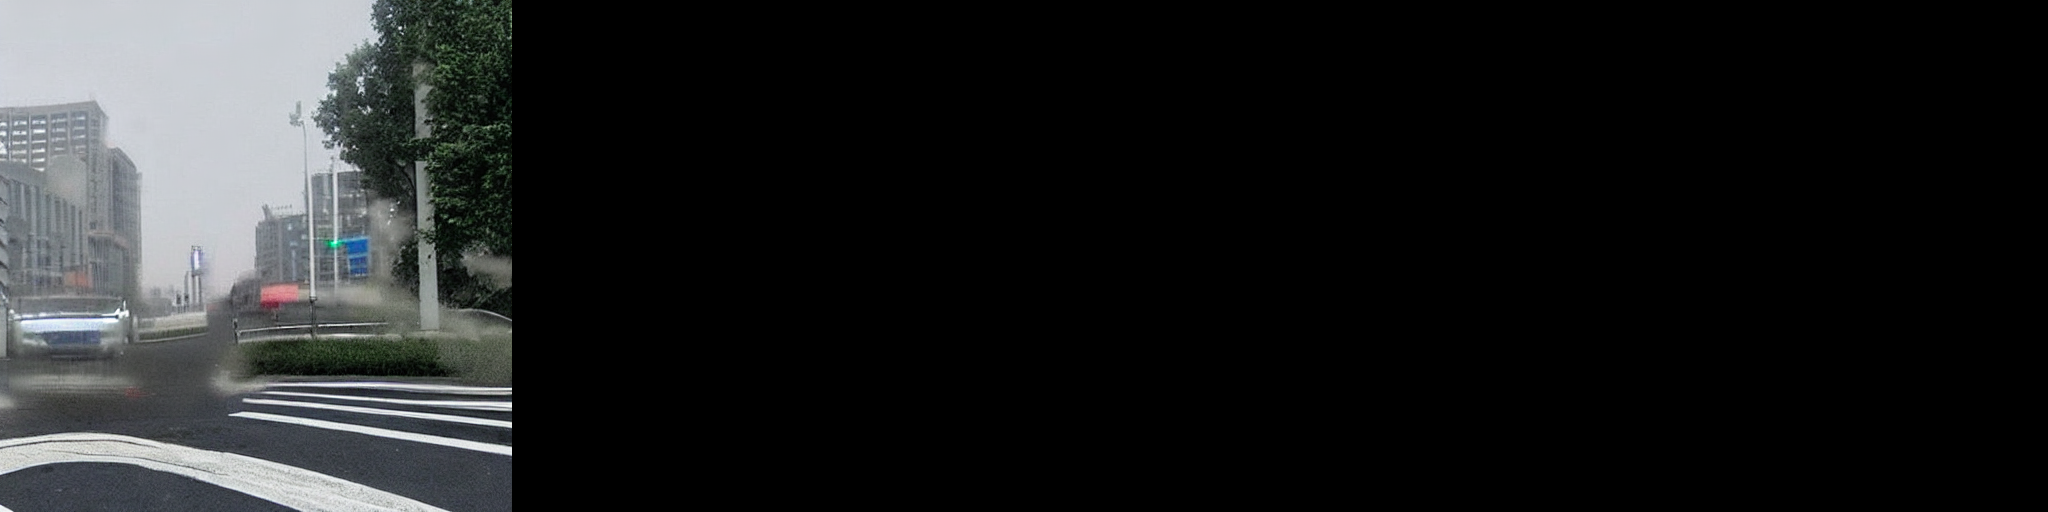

  0%|          | 0/251 [00:00<?, ?it/s]

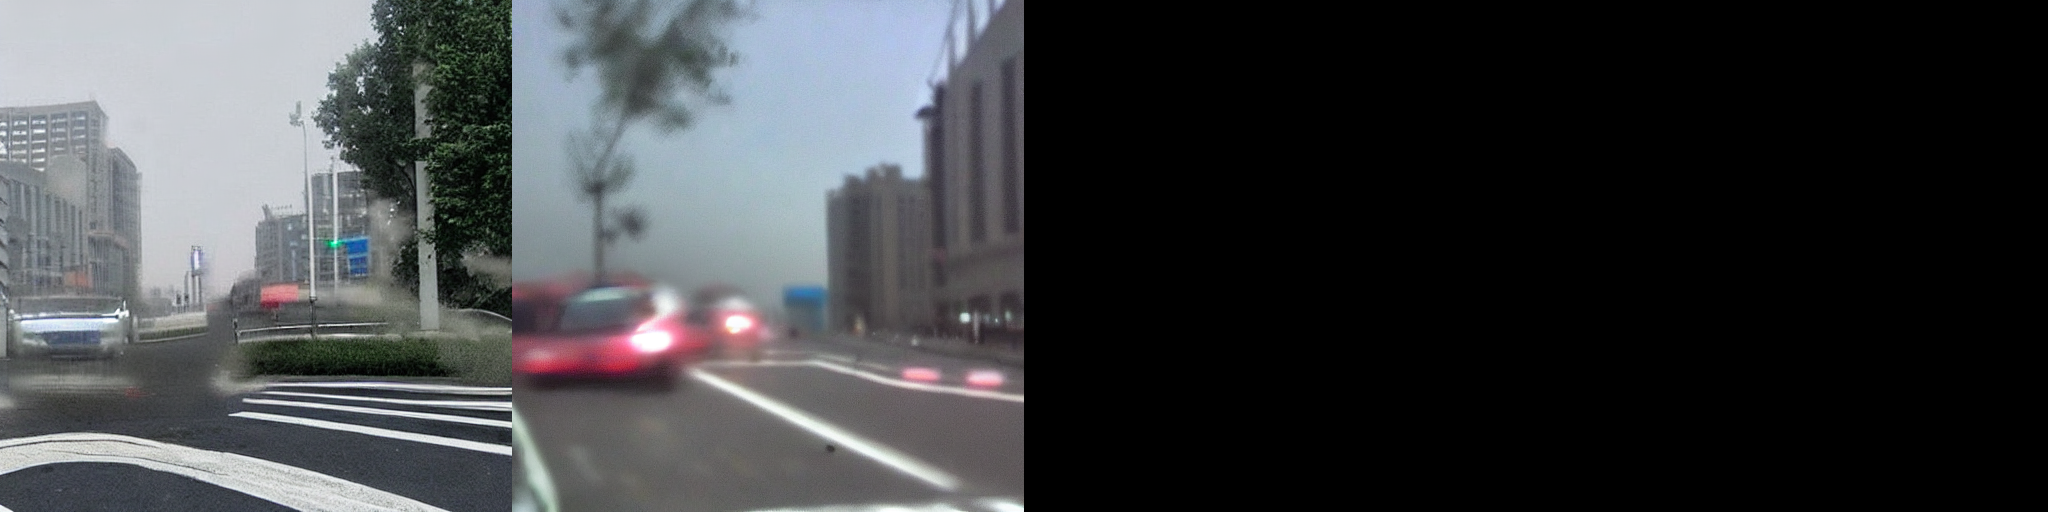

  0%|          | 0/251 [00:00<?, ?it/s]

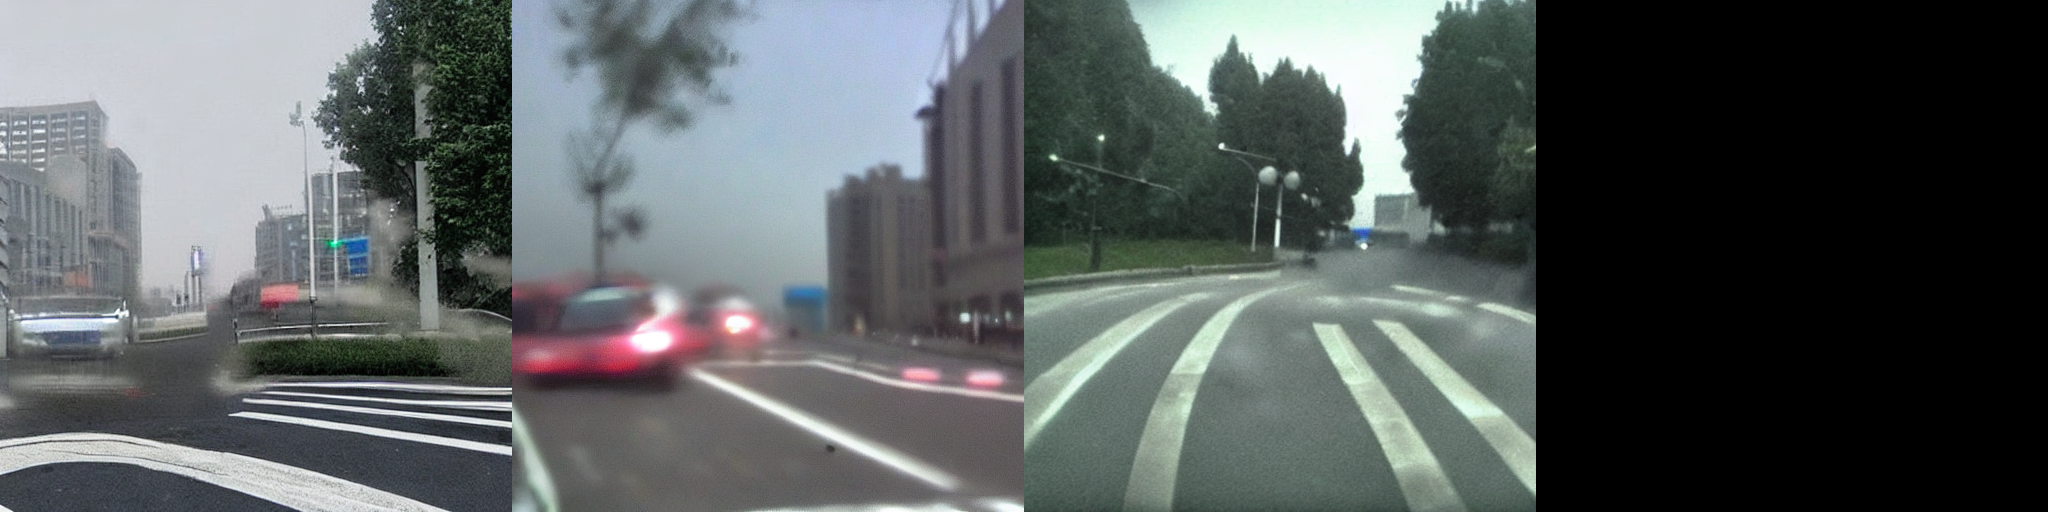

  0%|          | 0/251 [00:00<?, ?it/s]

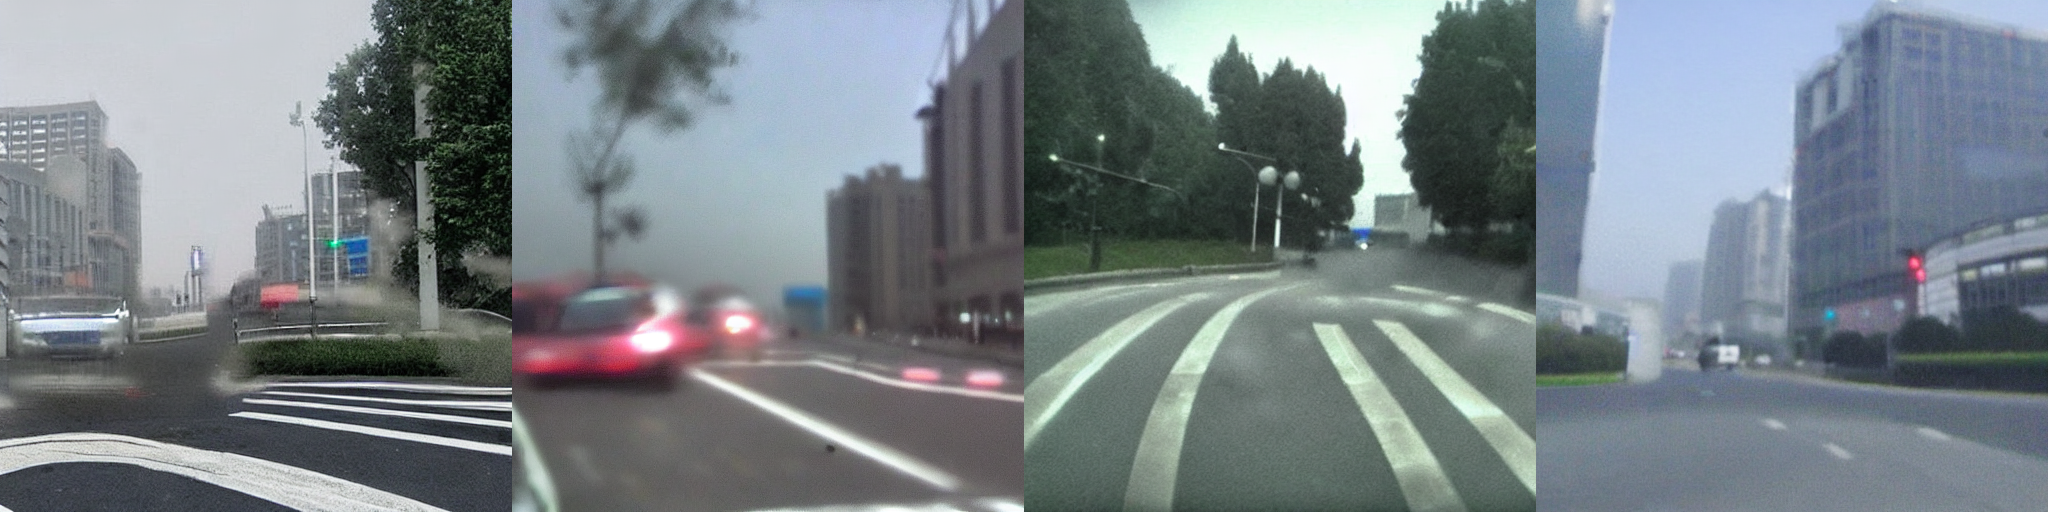

In [5]:
#@title Generate on Colab
grid = None
prompt = "a photorealistic image" # "a traffic scene, hyperrealistic, unreal engine"
#prompt = "a truck driving down the street next to a tree"
#@markdown `clip_prompt` is optional, if you leave it blank the same prompt is sent to Stable Diffusion and CLIP
clip_prompt = "" #@param {type: "string"}
num_samples = 4 #@param {type: "number"}
num_inference_steps = 250 #@param {type: "number"}
guidance_scale = 0.05 #@param {type: "number"}
clip_guidance_scale = 1200 #@param {type: "number"}
num_cutouts = 12 #@param {type: "number"}
use_cutouts = "True" #@param ["False", "True"]
unfreeze_unet = "False" #@param ["False", "True"]
unfreeze_vae = "False" #@param ["False", "True"]
seed = 42 #3788086447 #@param {type: "number"}

if unfreeze_unet == "True":
  guided_pipeline.unfreeze_unet()
else:
  guided_pipeline.freeze_unet()

if unfreeze_vae == "True":
  guided_pipeline.unfreeze_vae()
else:
  guided_pipeline.freeze_vae()

generator = torch.Generator(device="cuda").manual_seed(seed)

images = []
for i in range(num_samples):
    image = guided_pipeline(
        prompt,
        clip_prompt=clip_prompt if clip_prompt.strip() != "" else None,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale, 
        clip_guidance_scale=clip_guidance_scale,
        num_cutouts=num_cutouts,
        use_cutouts=use_cutouts == "True",
        generator=generator,
        num_images_per_prompt=2,
    ).images
    images.extend(image)

    grid = image_grid(images, 1, num_samples, grid)
    grid.show()